# Analysis of 10K tags (after we validated them)

Here we analyze how well our net (trained on the manual tags) performed on 10K random images. We found ground truth by manually going through the predictions. 

In [1]:
import os.path
import re
import sys
import tarfile
import time
import multiprocessing as mp
import itertools
import csv

import tensorflow.python.platform
from six.moves import urllib
import numpy as np
import tensorflow as tf
import h5py

import glob
import cPickle as pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.platform import gfile
from run_inference import predict_star, predict
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.style.use('ggplot')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [11]:
# get old tags

image_to_net_tag = pickle.load(open("/data/image_to_tags_10k.pkl", 'r'))
image_to_net_scores = pickle.load(open("/data/images_to_scores_10k.pkl", 'r'))
labels = []
with open("/data/retrain_manualtags1/output_labels700.txt", 'r') as ifile:
    for line in ifile:
        labels.append(line.rstrip().capitalize())
labels

['Animals',
 'Objects',
 'Maps',
 'Text',
 'Nature',
 'People',
 'Seals',
 'Miniatures',
 'Diagrams',
 'Architecture',
 'Decorations',
 'Landscape']

In [40]:
# get new tags

image_to_human_tag = {}

for folder in glob.glob("/data/images_validation_10k_cleaned/*"):  # correct ones
    tag = os.path.basename(folder)
    if tag not in labels: continue
    for jpg in glob.glob(folder + "/*.jpg"):
        img = os.path.basename(jpg).replace(".jpg", "")
        image_to_human_tag[img] = tag.lower()

for folder in glob.glob("/data/images_validation_10k_cleaned/brian_confusion/*"):  # correct ones
    tag = os.path.basename(folder)
    if 'temp' in tag: tag = tag.replace("_temp", "")
    for jpg in glob.glob(folder + "/*.jpg"):
        img = os.path.basename(jpg).replace(".jpg", "")
        image_to_human_tag[img] = tag.lower()

for folder in glob.glob("/data/images_validation_10k_cleaned/luda_confusion/*"):  # correct ones
    tag = os.path.basename(folder)
    if 'Temp' in tag: tag = tag.replace("_Temp", "")
    for jpg in glob.glob(folder + "/*.jpg"):
        img = os.path.basename(jpg).replace(".jpg", "")
        image_to_human_tag[img] = tag.lower()
            
for folder in glob.glob("/data/images_validation_10k_cleaned/karen_confusion/*"):  # correct ones
    tag = os.path.basename(folder)
    if 'temp' in tag: tag = tag.replace("_temp", "")
    for jpg in glob.glob(folder + "/*.jpg"):
        img = os.path.basename(jpg).replace(".jpg", "")
        image_to_human_tag[img] = tag.lower()
            

In [50]:
num_intop1 = 0
num_intop3 = 0
num_intop5 = 0
num_total = 0
image_to_tags = {}
for img in image_to_net_scores:
    top_3_tags = np.argsort(image_to_net_scores[img])[::-1][:3] 
    top_3_tags = [labels[x].lower() for x in top_3_tags]
    top_5_tags = np.argsort(image_to_net_scores[img])[::-1][:5] 
    top_5_tags = [labels[x].lower() for x in top_5_tags]
    
    if img not in image_to_human_tag: continue
    if image_to_human_tag[img] == image_to_net_tag[img]:
        num_intop1 += 1
    if image_to_human_tag[img] in top_3_tags:
        num_intop3 += 1
    if image_to_human_tag[img] in top_5_tags:
        num_intop5 += 1
    num_total += 1

print "Top 1 accuracy: {}".format(float(num_intop1)/num_total)
print "Top 3 accuracy: {}".format(float(num_intop3)/num_total)
print "Top 5 accuracy: {}".format(float(num_intop5)/num_total)
#print images_to_scores.keys()[:2]

Top 1 accuracy: 0.835819401341
Top 3 accuracy: 0.930123135449
Top 5 accuracy: 0.968265091601


In [51]:
# compare with each other --> confusion matrix and metrics

ground_y = []
pred_y = []
x = 0
for img in image_to_human_tag:
    if img not in image_to_net_tag:
        x+= 1 
        continue     
    else:
        ground_y.append(image_to_human_tag[img])
        pred_y.append(image_to_net_tag[img])

In [52]:
confm = confusion_matrix(ground_y, pred_y)
import pandas as pd
data = pd.DataFrame(confm)
data.columns = sorted(labels)
data.index = sorted(labels)
data

,Animals,Architecture,Decorations,Diagrams,Landscape,Maps,Miniatures,Nature,Objects,People,Seals,Text
Animals,283,0,0,1,3,25,2,9,10,11,4,28
Architecture,1,848,0,1,40,13,0,6,21,13,7,31
Decorations,2,2,901,3,1,19,41,1,18,1,26,44
Diagrams,4,3,1,449,0,30,1,1,12,0,1,30
Landscape,4,2,0,3,1283,34,1,31,12,16,2,94
Maps,0,0,0,4,0,594,0,13,1,2,0,22
Miniatures,0,3,14,1,0,7,264,0,8,0,41,10
Nature,12,0,0,0,5,27,0,862,5,4,0,62
Objects,8,1,0,10,3,30,1,2,563,2,10,31
People,40,3,0,3,7,121,11,81,45,1498,92,136


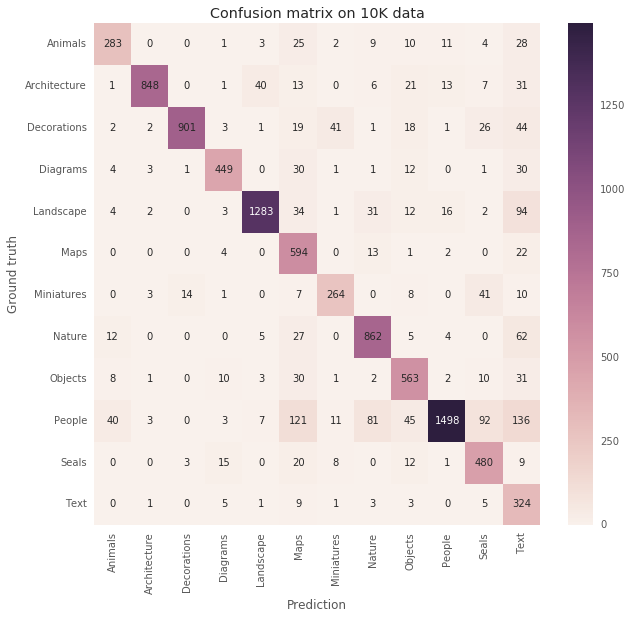

In [53]:
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111)
sns.heatmap(data, annot=True, fmt='d')
ax.set_xlabel("Prediction")
ax.set_ylabel("Ground truth")
plt.title("Confusion matrix on 10K data")
plt.savefig("confusion_matrix_10k.pdf", format='pdf')

In [89]:
# WE NEED TO ADD TAGS TO THE METADATA PICKLE (MANUAL + 10K) #
(image_metadata, book_metadata, image_to_idx) = pickle.load(open("/data/all_metadata.pkl", 'r'))

In [90]:
# add tag into metadata pickle for 10k

for img in image_to_human_tag:
    idx = image_to_idx[img]
    image_metadata[idx][-1] = image_to_human_tag[img]

In [100]:
# add tag into metadata pickle for manual 1500

counter = 0
with open("/home/ubuntu/ArtHistoryNet/analysis/20160228_image_to_manual_tags.csv", 'r') as ifile:
    for line in ifile:
        row = line.split('| ')
        if len(row) < 2: continue
        name = row[0].split('|')[1]
        imgname = '_'.join(name.split('_')[:4]) + '_'
        tag = row[1].rstrip().lower()
        
        if imgname in image_to_idx:
            idx = image_to_idx[imgname]
            image_metadata[idx][-1] = tag
            counter += 1

print counter        

1346


In [102]:
pickle.dump((image_metadata, book_metadata, image_to_idx), open("/data/all_metadata_w11ktags.pkl", 'w'))

In [83]:
for img in image_to_net_tag:
    if img not in image_to_human_tag: continue
    if image_to_net_tag[img] == "decorations" and image_to_human_tag[img] == "miniatures":
        print img

001253944_0_000087_1_
004014492_02_000113_1_
003421394_0_000375_1_
003542706_01_000125_1_
002528499_0_000188_2_
003314928_01_000007_1_
001216372_01_000168_2_
003257008_0_000204_1_
002895626_0_000115_1_
001744607_03_000013_2_
001176069_0_000053_1_
003392660_0_000181_1_
002556396_0_000044_2_
002367074_03_000142_2_


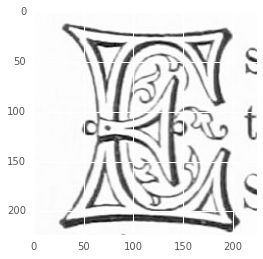

In [87]:
plt.imshow(mpimg.imread("/data/images_validation_10k/Decorations/004014492_02_000113_1_.jpg"), cmap = mpl.cm.Greys_r)